# NB02: Metal Score × Isolation Environment

Test whether organisms from metal-contaminated environments have higher
predicted metal tolerance scores than organisms from other environments.

Includes power analysis, Mann-Whitney U tests, and phylum-stratified
permutation tests to control for phylogenetic confounding.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

PROJ = os.path.abspath('..')
DATA_OUT = os.path.join(PROJ, 'data')
FIG_OUT = os.path.join(PROJ, 'figures')

In [2]:
# Load matched strains from NB01
df = pd.read_csv(os.path.join(DATA_OUT, 'matched_strains.csv'))
print(f'Matched strains: {len(df)}')
print(f'With isolation data: {df["cat1"].notna().sum()}')
print(f'With metal scores: {df["metal_score_norm"].notna().sum()}')

# Work with strains that have both isolation data and metal scores
df = df[df['cat1'].notna() & df['metal_score_norm'].notna()].copy()
print(f'\nWorking set (isolation + metal score): {len(df)}')

Matched strains: 42227
With isolation data: 25089
With metal scores: 42227

Working set (isolation + metal score): 25089


## Power analysis for n=31 heavy metal group

In [3]:
# Compute minimum detectable effect size at 80% power for Mann-Whitney U
# Approximation: Mann-Whitney is ~95% as efficient as t-test for normal data
# Use t-test power formula as approximation
from scipy.stats import norm

def min_detectable_effect(n1, n2, alpha=0.05, power=0.80):
    """Approximate minimum detectable Cohen's d for two-sample test."""
    z_alpha = norm.ppf(1 - alpha/2)
    z_beta = norm.ppf(power)
    # Pooled effective n
    n_eff = (n1 * n2) / (n1 + n2)
    d = (z_alpha + z_beta) / np.sqrt(n_eff)
    # Adjust for Mann-Whitney efficiency
    d_mw = d / 0.95
    return d_mw

# Heavy metal group
n_hm = len(df[df.cat3 == '#Heavy metal'])
n_baseline = len(df[df.cat1 == '#Environmental'])
d_min = min_detectable_effect(max(n_hm, 1), n_baseline)
print(f'Heavy metal group: n={n_hm}')
print(f'Environmental baseline: n={n_baseline}')
print(f'Minimum detectable effect (Cohen\'s d) at 80% power: {d_min:.2f}')
print(f'This means we can detect a shift of {d_min:.2f} standard deviations in metal score')

# Also for broader contamination group
n_contam = len(df[df.cat2 == '#Contamination'])
d_min_contam = min_detectable_effect(max(n_contam, 1), n_baseline)
print(f'\nContamination group: n={n_contam}')
print(f'Minimum detectable effect: d={d_min_contam:.2f}')

# What does this mean in metal_score_norm units?
score_std = df['metal_score_norm'].std()
print(f'\nMetal score std: {score_std:.4f}')
print(f'Minimum detectable shift (heavy metal): {d_min * score_std:.4f} score units')
print(f'Minimum detectable shift (contamination): {d_min_contam * score_std:.4f} score units')

Heavy metal group: n=10
Environmental baseline: n=7356
Minimum detectable effect (Cohen's d) at 80% power: 0.93
This means we can detect a shift of 0.93 standard deviations in metal score

Contamination group: n=176
Minimum detectable effect: d=0.22

Metal score std: 0.0443
Minimum detectable shift (heavy metal): 0.0413 score units
Minimum detectable shift (contamination): 0.0100 score units


## Compare metal scores across environment categories

In [4]:
# Define comparisons
env_baseline = df[df.cat1 == '#Environmental']['metal_score_norm']

comparisons = [
    ('Heavy metal contamination', df[df.cat3 == '#Heavy metal']['metal_score_norm'], 'cat3=#Heavy metal'),
    ('All contamination', df[df.cat2 == '#Contamination']['metal_score_norm'], 'cat2=#Contamination'),
    ('Industrial', df[df.cat2 == '#Industrial']['metal_score_norm'], 'cat2=#Industrial'),
    ('Waste/sludge', df[df.cat2 == '#Waste']['metal_score_norm'], 'cat2=#Waste'),
    ('Host-associated', df[df.cat1 == '#Host']['metal_score_norm'], 'cat1=#Host'),
]

results = []
print(f'Environmental baseline: n={len(env_baseline)}, median={env_baseline.median():.4f}, mean={env_baseline.mean():.4f}')
print(f'\n{"Comparison":35s} | {"n":>5s} | {"Median":>8s} | {"Mean":>8s} | {"Delta":>8s} | {"Cohen d":>8s} | {"U stat":>10s} | {"p-value":>10s}')
print('-' * 115)

for name, group, label in comparisons:
    if len(group) < 3:
        print(f'{name:35s} | {len(group):5d} | SKIPPED (n<3)')
        continue
    
    # Mann-Whitney U test
    u_stat, p_val = stats.mannwhitneyu(group, env_baseline, alternative='two-sided')
    
    # Cohen's d
    pooled_std = np.sqrt((group.std()**2 + env_baseline.std()**2) / 2)
    cohens_d = (group.mean() - env_baseline.mean()) / pooled_std if pooled_std > 0 else 0
    
    delta = group.median() - env_baseline.median()
    
    print(f'{name:35s} | {len(group):5d} | {group.median():8.4f} | {group.mean():8.4f} | {delta:+8.4f} | {cohens_d:+8.3f} | {u_stat:10.0f} | {p_val:10.2e}')
    
    results.append({
        'comparison': name,
        'label': label,
        'n_group': len(group),
        'n_baseline': len(env_baseline),
        'median_group': group.median(),
        'median_baseline': env_baseline.median(),
        'mean_group': group.mean(),
        'mean_baseline': env_baseline.mean(),
        'delta_median': delta,
        'cohens_d': cohens_d,
        'u_statistic': u_stat,
        'p_value': p_val,
    })

results_df = pd.DataFrame(results)

Environmental baseline: n=7356, median=0.1869, mean=0.1948

Comparison                          |     n |   Median |     Mean |    Delta |  Cohen d |     U stat |    p-value
-------------------------------------------------------------------------------------------------------------------
Heavy metal contamination           |    10 |   0.2396 |   0.2355 |  +0.0528 |   +0.996 |      55172 |   5.84e-03
All contamination                   |   176 |   0.2148 |   0.2114 |  +0.0280 |   +0.434 |     816422 |   2.35e-09
Industrial                          |   796 |   0.1987 |   0.2023 |  +0.0119 |   +0.197 |    3301261 |   2.61e-09
Waste/sludge                        |   305 |   0.2188 |   0.2177 |  +0.0319 |   +0.571 |    1486143 |   3.38e-22
Host-associated                     | 12086 |   0.1940 |   0.2009 |  +0.0071 |   +0.142 |   47255828 |   1.46e-13


## Phylogenetic confounding check

In [5]:
# Check genus/phylum distribution in heavy metal vs baseline
hm = df[df.cat3 == '#Heavy metal']
env = df[df.cat1 == '#Environmental']

print('=== Phylum distribution ===')
print(f'\nHeavy metal contamination (n={len(hm)}):')
if len(hm) > 0:
    print(hm['bacdive_phylum'].value_counts().head(10).to_string())

print(f'\nEnvironmental baseline (n={len(env)}):')
print(env['bacdive_phylum'].value_counts().head(10).to_string())

print(f'\n=== Genus distribution (heavy metal) ===')
if len(hm) > 0:
    print(hm['bacdive_genus'].value_counts().head(15).to_string())

# Contamination group
contam = df[df.cat2 == '#Contamination']
print(f'\n=== Genus distribution (all contamination, n={len(contam)}) ===')
if len(contam) > 0:
    print(contam['bacdive_genus'].value_counts().head(15).to_string())

=== Phylum distribution ===

Heavy metal contamination (n=10):
bacdive_phylum
Pseudomonadota    4
Actinomycetota    4
Bacillota         1
Deinococcota      1

Environmental baseline (n=7356):
bacdive_phylum
Pseudomonadota             5655
Actinomycetota              772
Bacillota                   492
Bacteroidota                156
Methanobacteriota            88
Deinococcota                 37
Thermodesulfobacteriota      36
Thermoproteota               30
Planctomycetota              18
Thermotogota                 13

=== Genus distribution (heavy metal) ===
bacdive_genus
Cupriavidus           1
Clostridium           1
Deinococcus           1
Leucobacter           1
Cellulosimicrobium    1
Halopseudomonas       1
Amycolatopsis         1
Agromyces             1
Luteimonas            1
Herbaspirillum        1

=== Genus distribution (all contamination, n=176) ===
bacdive_genus
Rhodococcus          14
Mycobacterium         9
Sphingobium           9
Janibacter            7
Anaeromyxoba

In [6]:
# Phylum-stratified permutation test
# For each major phylum, test contamination vs environmental within that phylum
print('=== Phylum-stratified analysis ===')
print('(contamination vs environmental within each phylum)\n')

contam_all = df[df.cat2 == '#Contamination']
env_all = df[df.cat1 == '#Environmental']

major_phyla = df['bacdive_phylum'].value_counts().head(6).index.tolist()

strat_results = []
for phylum in major_phyla:
    contam_p = contam_all[contam_all.bacdive_phylum == phylum]['metal_score_norm']
    env_p = env_all[env_all.bacdive_phylum == phylum]['metal_score_norm']
    
    if len(contam_p) < 3 or len(env_p) < 3:
        print(f'{phylum:30s}: contam n={len(contam_p)}, env n={len(env_p)} — SKIPPED')
        continue
    
    u, p = stats.mannwhitneyu(contam_p, env_p, alternative='two-sided')
    delta = contam_p.median() - env_p.median()
    
    print(f'{phylum:30s}: contam n={len(contam_p)}, env n={len(env_p)}, '
          f'delta={delta:+.4f}, p={p:.3f}')
    
    strat_results.append({
        'phylum': phylum,
        'n_contam': len(contam_p),
        'n_env': len(env_p),
        'median_contam': contam_p.median(),
        'median_env': env_p.median(),
        'delta': delta,
        'p_value': p,
    })

if strat_results:
    strat_df = pd.DataFrame(strat_results)
    n_positive = (strat_df['delta'] > 0).sum()
    n_sig = (strat_df['p_value'] < 0.05).sum()
    print(f'\nSummary: {n_positive}/{len(strat_df)} phyla show positive delta, '
          f'{n_sig}/{len(strat_df)} significant')

=== Phylum-stratified analysis ===
(contamination vs environmental within each phylum)

Pseudomonadota                : contam n=85, env n=5655, delta=+0.0400, p=0.000
Bacillota                     : contam n=19, env n=492, delta=-0.0121, p=0.285
Actinomycetota                : contam n=62, env n=772, delta=+0.0347, p=0.000
Bacteroidota                  : contam n=5, env n=156, delta=-0.0079, p=0.456
Methanobacteriota             : contam n=0, env n=88 — SKIPPED
Fusobacteriota                : contam n=0, env n=0 — SKIPPED

Summary: 2/4 phyla show positive delta, 2/4 significant


## Visualization

/tmp/ipykernel_17668/3392940906.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[0].boxplot(plot_data, labels=plot_labels, patch_artist=True, widths=0.6)
/tmp/ipykernel_17668/3392940906.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=violin_data, x='Category', y='Metal Score', ax=axes[1],


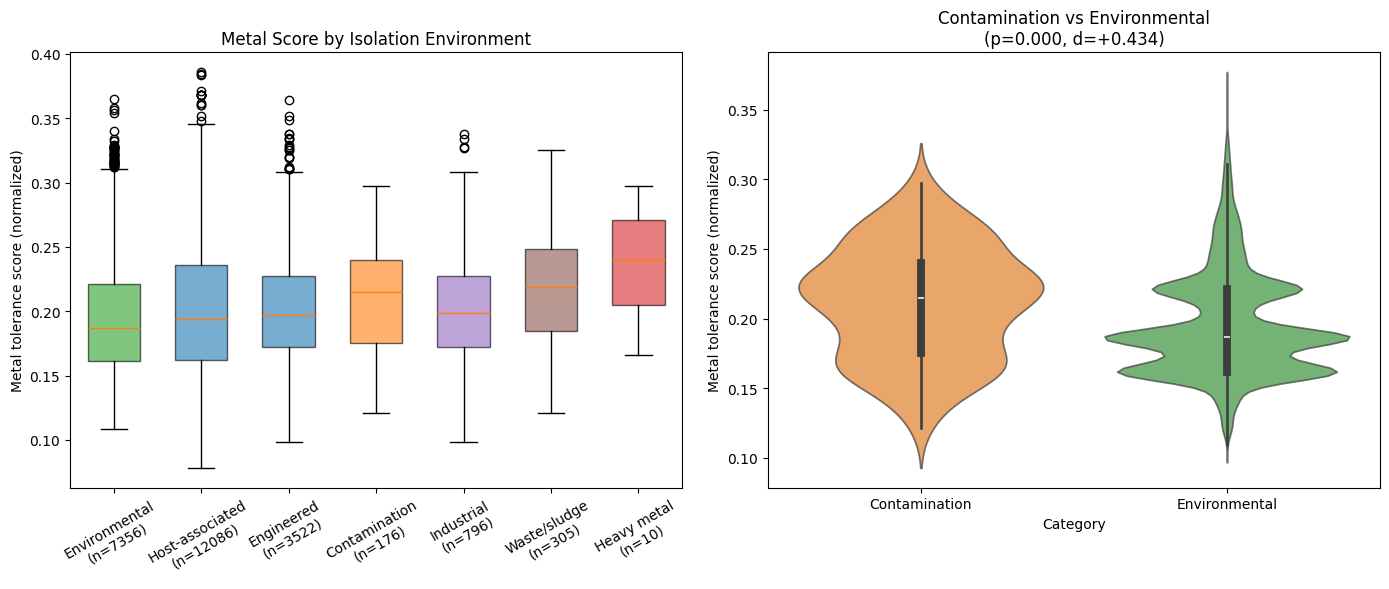

Saved: figures/metal_score_by_environment.png


In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Panel 1: Boxplot of metal scores by environment category
env_categories = [
    ('#Environmental', 'Environmental'),
    ('#Host', 'Host-associated'),
    ('#Engineered', 'Engineered'),
]

# Add specific contamination/industrial/waste categories
plot_data = []
plot_labels = []
plot_colors = []

for cat1, label in env_categories:
    sub = df[df.cat1 == cat1]['metal_score_norm'].dropna()
    if len(sub) >= 3:
        plot_data.append(sub.values)
        plot_labels.append(f'{label}\n(n={len(sub)})')
        plot_colors.append('#2ca02c' if cat1 == '#Environmental' else '#1f77b4')

# Add contamination subgroups
for cat2, label, color in [
    ('#Contamination', 'Contamination', '#ff7f0e'),
    ('#Industrial', 'Industrial', '#9467bd'),
    ('#Waste', 'Waste/sludge', '#8c564b'),
]:
    sub = df[df.cat2 == cat2]['metal_score_norm'].dropna()
    if len(sub) >= 3:
        plot_data.append(sub.values)
        plot_labels.append(f'{label}\n(n={len(sub)})')
        plot_colors.append(color)

# Heavy metal specifically
hm_scores = df[df.cat3 == '#Heavy metal']['metal_score_norm'].dropna()
if len(hm_scores) >= 3:
    plot_data.append(hm_scores.values)
    plot_labels.append(f'Heavy metal\n(n={len(hm_scores)})')
    plot_colors.append('#d62728')

bp = axes[0].boxplot(plot_data, labels=plot_labels, patch_artist=True, widths=0.6)
for patch, color in zip(bp['boxes'], plot_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
axes[0].set_ylabel('Metal tolerance score (normalized)')
axes[0].set_title('Metal Score by Isolation Environment')
axes[0].tick_params(axis='x', rotation=30)

# Panel 2: Violin plot for contamination vs environmental
if len(contam_all) > 0 and len(env_all) > 0:
    violin_data = pd.DataFrame({
        'Metal Score': pd.concat([contam_all['metal_score_norm'], env_all['metal_score_norm']]),
        'Category': ['Contamination']*len(contam_all) + ['Environmental']*len(env_all),
    })
    sns.violinplot(data=violin_data, x='Category', y='Metal Score', ax=axes[1],
                   palette=['#ff7f0e', '#2ca02c'], alpha=0.7)
    
    # Add significance annotation
    contam_result = results_df[results_df.comparison == 'All contamination']
    if len(contam_result) > 0:
        p = contam_result.iloc[0]['p_value']
        d = contam_result.iloc[0]['cohens_d']
        axes[1].set_title(f'Contamination vs Environmental\n(p={p:.3f}, d={d:+.3f})')
    else:
        axes[1].set_title('Contamination vs Environmental')
    axes[1].set_ylabel('Metal tolerance score (normalized)')

plt.tight_layout()
plt.savefig(os.path.join(FIG_OUT, 'metal_score_by_environment.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: figures/metal_score_by_environment.png')

In [8]:
# Save results
results_df.to_csv(os.path.join(DATA_OUT, 'environment_metal_scores.csv'), index=False)
print(f'Saved: data/environment_metal_scores.csv')

if strat_results:
    strat_df.to_csv(os.path.join(DATA_OUT, 'phylum_stratified_tests.csv'), index=False)
    print(f'Saved: data/phylum_stratified_tests.csv')

print(f'\n=== KEY RESULTS ===')
for _, row in results_df.iterrows():
    sig = '*' if row['p_value'] < 0.05 else 'ns'
    print(f'{row["comparison"]:35s}: d={row["cohens_d"]:+.3f}, p={row["p_value"]:.3f} {sig}')

Saved: data/environment_metal_scores.csv
Saved: data/phylum_stratified_tests.csv

=== KEY RESULTS ===
Heavy metal contamination          : d=+0.996, p=0.006 *
All contamination                  : d=+0.434, p=0.000 *
Industrial                         : d=+0.197, p=0.000 *
Waste/sludge                       : d=+0.571, p=0.000 *
Host-associated                    : d=+0.142, p=0.000 *
